# tSZ analysis using CMB frequency maps
A fit on a set of simulated CMB frequency maps using Cobaya.

## Simulation 
The frequency maps are simulated using galaxy cluster spatial profile templates.
In this example tSZ spatial profiles created by Emanuale D'Angelo is used (tsz_template.fits and vmaps.fits). 
Only first four frequency channels are used.
Also, please note that the cluster templates are convolved with a beam.

$Obs_{tSZ}(\nu) = f(y_{cl},\nu)T(\nu) + N\sqrt{V(\nu)}$

$T(\nu)$ - template for the galaxy cluster spatial profile.
$N$ - random normal matrix.
$V(\nu)$ - Variance map.

$f(y_{cl}, \nu)$ is the amplitude of the tSZ signal in the corresponding frequency band. Which is given the tSZ spectrum functions code by Gemma Luzzi.


The $χ^{2}$ and the likelihood is defined as

$χ^{2} =  \sum\limits_{\nu} \sum\limits_{i,j} \frac{[f(y_{cl},\nu)T_{\nu}(i,j) - Obs_{\nu}(i,j)]^{2}}{V_{\nu}(i,j)}$

$P(Obs_{tSZ}|y_{cl}) \propto  exp(-χ^{2})$

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sz_spectrum as f_sz
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from cobaya.run import run
import scipy.ndimage as ndimage

In [2]:
def show_image_line(images, figtitle = None, labels = [], output = None):

    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images*3,3))
    for i in range(num_images):
        ax=axs[i]
        if len(labels) != 0:
            ax.set_title(labels[i])
        image=ax.imshow(images[i])
        plt.colorbar(image, orientation='horizontal', shrink=0.7, ticks = [np.min(images[i]), np.max(images[i])])

    fig.suptitle(figtitle, fontsize=16)

    fig.tight_layout()
    if output == None:
        plt.show()
    else:
        plt.savefig(output, dpi=300)

In [3]:
# Input data: Frequency maps and corresponding variance maps

noise_scale = 1000
#set input and output folders
input_folder = "/home/vipul/sz_analysis/MappeMock/"
cobaya_output_folder = "/home/vipul/Y-maps/cobaya_output/"

cluster_name = "psz2g346.61+35.06" #"psz2g263.68-22.55" 
cluster_tsz_template = fits.open(input_folder + "{}/PR2/{}_noysz217_tsz_template.fits".format(cluster_name, cluster_name))[0].data
#varmaps unit microkelvin. 
cluster_var_maps = fits.open(input_folder + "{}/PR2/{}_noysz217_vmaps.fits".format(cluster_name, cluster_name))[0].data*1e3/noise_scale
grid_size = np.shape(cluster_tsz_template[0])[0] 
cluster_stddev = np.sqrt(cluster_var_maps)

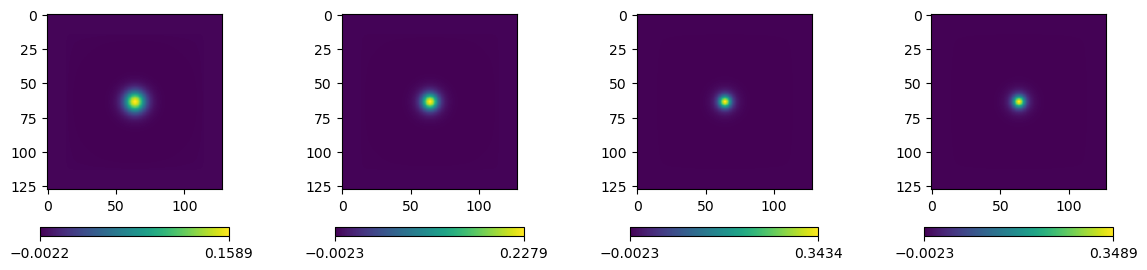

In [7]:
show_image_line(cluster_tsz_template[0:4])

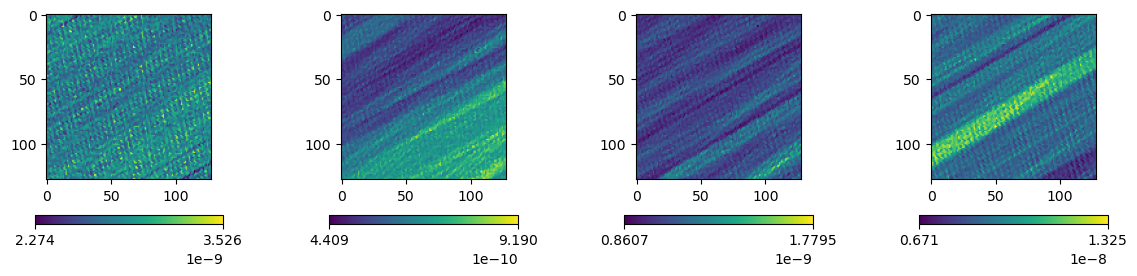

In [8]:
show_image_line(cluster_var_maps[0:4])

[-0.4065394  -0.28288995  0.0201081   0.65056721]


Text(0.5, 1.0, 'tSZ signal amplitude')

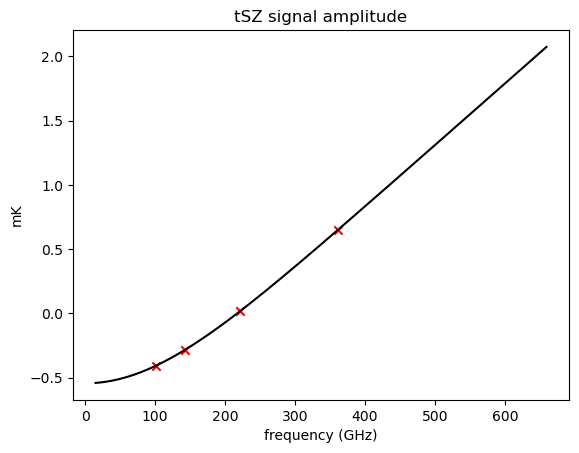

In [4]:
# Amplitude of the tSZ signal

#Physical constants for calculating the spectral amplitude
t0=2.725
me=510.99890
c=2.99792e10
c_km=c*1e-5
kb=1.380650e-23
h=6.62607e-34
cn=c*1e-9
hc=h*c
co=1.

const = {'t0':t0,'me':me,'c':c, 'c_km':c*1e-5,'cn':c*1e-9,'kb':kb,'h':h,'hc':hc,'co':co}

# Frequency initialization
n_min=0.5
n_max=22
step_ni=0.01
n_ni=round((n_max-n_min)/step_ni)
ni=n_min*np.ones(n_ni)+step_ni*np.array(range(n_ni))
nu_GHz=ni*cn
pxsize=128
centerfreq = np.array([100.000, 143.000, 217.000, 353.0005]) # the four frequency bands used
n_freq=len(centerfreq)
Rmask=5

Ycl_input = 1e-4 # input value for cluster y parameter
T_kev = 0
V_pec = 0
Z = 0.1
Tcmb = t0*(1+Z)

# tSZ spectral shape is given by 
f_nu = f_sz.rel_corr_batch_bis(Ycl_input, T_kev, V_pec, Tcmb,nu_GHz*(1.+Z), const, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), 6) 

# The band integrated value of the tSZ spectral amplitude for frequency bands is given by following
f_nu_band_intgrated = f_sz.sz_forecast(Ycl_input, T_kev, V_pec, Tcmb, Z, centerfreq, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), nu_GHz, const, bandf='pl_bandpass_2013.sav', typ=6)

eff_freq = [101.31, 142.709, 221.914, 361.289] # effective frequeny, to be used with band integrated spectrum

print(f_nu_band_intgrated)

plt.plot(nu_GHz, f_nu, 'k')
plt.scatter(eff_freq, f_nu_band_intgrated, marker = 'x', color = 'red')
plt.xlabel(r"frequency (GHz)")
plt.ylabel(r"mK")
plt.title("tSZ signal amplitude")

[-0.0979775  -0.10460758  0.00932742  0.17557263]


Text(0.5, 1.0, 'tSZ signal amplitude')

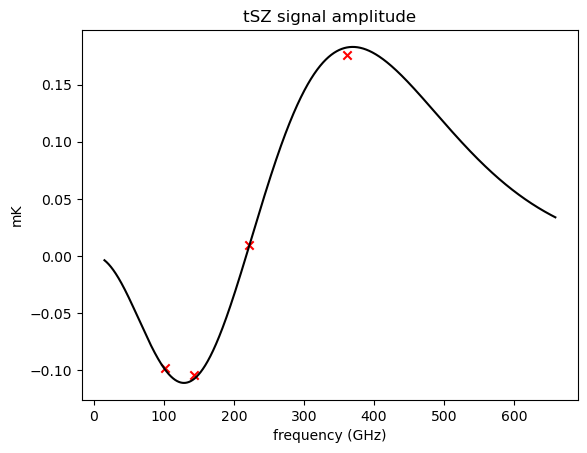

In [7]:
# tSZ spectral shape is given by 
f_nu = f_sz.rel_corr_batch_bis(Ycl_input, T_kev, V_pec, Tcmb,nu_GHz*(1.+Z), const, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), 6, temp=False) 

# The band integrated value of the tSZ spectral amplitude for frequency bands is given by following
f_nu_band_intgrated = f_sz.sz_forecast(Ycl_input, T_kev, V_pec, Tcmb, Z, centerfreq, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), nu_GHz, const, bandf='pl_bandpass_2013.sav', typ=6, temp=False )

eff_freq = [101.31, 142.709, 221.914, 361.289] # effective frequeny, to be used with band integrated spectrum

print(f_nu_band_intgrated)

plt.plot(nu_GHz, f_nu, 'k')
plt.scatter(eff_freq, f_nu_band_intgrated, marker = 'x', color = 'red')
plt.xlabel(r"frequency (GHz)")
plt.ylabel(r"mK")
plt.title("tSZ signal amplitude")


---100.0 GHz---
max template =  0.15890776
f nu =  -0.4065393991938219
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  5.9380563e-05
SNR =  0.0

---143.0 GHz---
max template =  0.22786653
f nu =  -0.2828899475114373
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  3.031433e-05
SNR =  0.0

---217.0 GHz---
max template =  0.3433765
f nu =  0.020108097687773042
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  4.2183918e-05
SNR =  0.0

---353.0005 GHz---
max template =  0.34885168
f nu =  0.650567207358721
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  0.00011510729
SNR =  0.0


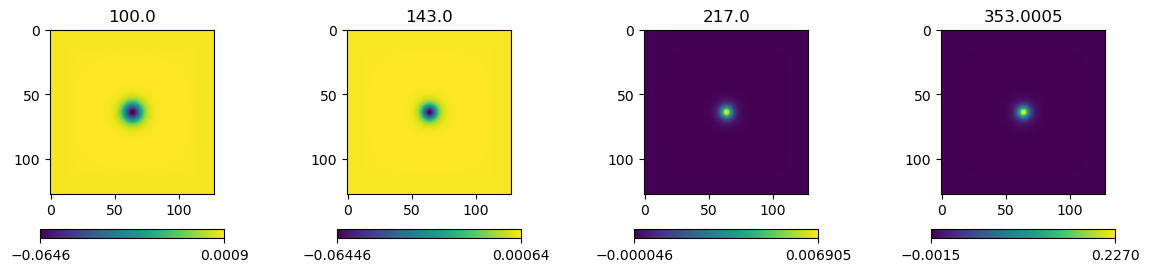

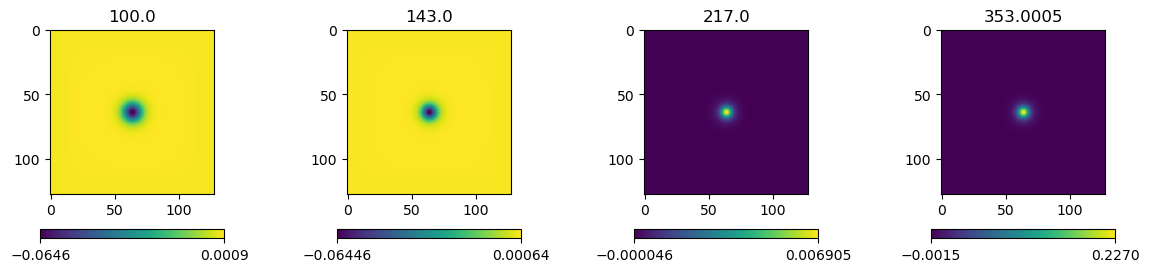

In [10]:
# Creating the simulated frequency maps

Map_obs_nu = np.zeros((n_freq,grid_size, grid_size))
noise_nu = np.zeros((n_freq,grid_size, grid_size))
Ycl_map_nu = np.zeros((n_freq,grid_size, grid_size))

for i in range(n_freq):
  print("\n---{} GHz---".format(centerfreq[i]))
  noise = np.multiply(cluster_stddev[i], np.random.normal(0, 1, size = (grid_size,grid_size)))/noise_scale
  Ycl_map = f_nu_band_intgrated[i]*cluster_tsz_template[i]
  print("max template = ", np.max(cluster_tsz_template[i]))
  print("f nu = ", f_nu_band_intgrated[i])
  print("Max of f(nu)*template = ", np.max(np.abs(Ycl_map[i])))
  print("Max of sqrt(cluster_vmaps) = ", np.max(np.abs(cluster_stddev[i])))
  print("SNR = ", np.max(np.abs(Ycl_map[i]))/np.max(np.abs(cluster_stddev[i])))
  # Map_obs = np.add(ndimage.gaussian_filter(Ycl_map, sigma=sigma_10arcmin, order=0, axes=0), noise)
  Map_obs = np.add(Ycl_map, noise)

  Ycl_map_nu[i,:,:] = Ycl_map
  noise_nu[i,:,:] = noise
  Map_obs_nu[i,:,:] = Map_obs

show_image_line(Ycl_map_nu, labels = centerfreq)
show_image_line(Map_obs_nu, labels = centerfreq)

In [11]:
# fit using Cobaya

def likelihood_Ysz(Ycl):
  # likelikhood = exp(- chi_squure)
  f_nu_band_intgrated_val = f_sz.sz_forecast(Ycl, T_kev, V_pec, Tcmb, Z, centerfreq, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), nu_GHz, const, bandf='pl_bandpass_2013.sav', typ = 6)
  Map_predict_nu = np.zeros((n_freq,grid_size, grid_size))
  for i in range(n_freq):
    Map_predict_nu[i,:,:] = f_nu_band_intgrated_val[i]*cluster_tsz_template[i,:,:]
  chisqr = np.sum((Map_obs_nu - Map_predict_nu)**2/cluster_var_maps[0:4])
  return -chisqr

info={
      "likelihood": {"chisqr": likelihood_Ysz},
      "params": {"Ycl": {"prior":{"min":1e-6, "max":1e-3}, "ref":{"dist": 'norm', "loc":Ycl_input, "scale":Ycl_input}, "proposal":Ycl_input/30}},
      "sampler": {"mcmc": {"Rminus1_stop": 0.008, "max_tries": 100000, "learn_proposal":True}},
      "force": True
      }

if not os.path.exists(cobaya_output_folder+cluster_name):
      os.mkdir(cobaya_output_folder+cluster_name)

info["output"] = cobaya_output_folder +"{}_freqmaps_analysis_cobaya".format(cluster_name)
print(info)

updated_info_Ycl, sampler_Ycl = run(info)
updated_info_minimizer_Ycl, minimizer_Ycl = run(info, minimize=True)

{'likelihood': {'chisqr': <function likelihood_Ysz at 0x7ddb4d443ac0>}, 'params': {'Ycl': {'prior': {'min': 1e-06, 'max': 0.001}, 'ref': {'dist': 'norm', 'loc': 0.0001, 'scale': 0.0001}, 'proposal': 3.3333333333333333e-06}}, 'sampler': {'mcmc': {'Rminus1_stop': 0.008, 'max_tries': 100000, 'learn_proposal': True}}, 'force': True, 'output': '/home/vipul/Y-maps/cobaya_output/psz2g346.61+35.06_freqmaps_analysis_cobaya'}
[output] Output to be read-from/written-into folder '/home/vipul/Y-maps/cobaya_output', with prefix 'psz2g346.61+35.06_freqmaps_analysis_cobaya'
[output] Found existing info files with the requested output prefix: '/home/vipul/Y-maps/cobaya_output/psz2g346.61+35.06_freqmaps_analysis_cobaya'
[output] Will delete previous products ('force' was requested).
[chisqr] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: Ycl:0.0001381187
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measure

   weight  minuslogpost     Ycl  minuslogprior  minuslogprior__0      chi2  \
0     1.0     -6.908096  0.0001      -6.908756         -6.908756  0.001319   

   chi2__chisqr  
0      0.001319  
[root] *WARNING* outlier fraction 0.06184668989547038 
Mean: 0.00010000613183128388
Covariance matrix, stddev: [[7.21617821e-15]] 8.494809126029692e-08
[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.000658725918440115,N_eff=738.8975829578042). Using fallback (h=0.00649330264082863)


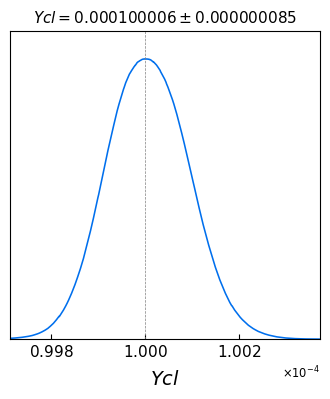

In [40]:
print(minimizer_Ycl.products()["minimum"])
peak_ycl = minimizer_Ycl.products()["minimum"]["Ycl"]
ycl_limits = {'Ysz': (Ycl_input - 1.5e-4, Ycl_input + 1.5e-4)} #x-axis limits to make the plot symmetric wrt peak.

# Export the results to GetDist
gd_sample = sampler_Ycl.products(skip_samples=0.3, to_getdist=True)["sample"]

# Analyze and plot
Ycl_fit = gd_sample.getMeans(pars = [0])[0]
Ycl_fit_covariance = gd_sample.getCovMat().matrix
Ycl_fit_stddev = np.sqrt(Ycl_fit_covariance[0][0])
print("Mean:", Ycl_fit)
print("Covariance matrix, stddev:", Ycl_fit_covariance, Ycl_fit_stddev)
# uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter(subplot_size = 4)
gdplot.triangle_plot(gd_sample, ["Ycl"], filled=True, markers={"Ycl":Ycl_input},title_limit = 1)

## Second order correction (Fabbri et al.)
h_nu = rel_corr_sec_ord_ysz(y_sz, Yp, Tcmb, tkev = T_kev, freq_GHz = nu_GHz*(1+Z), const=const, temp = temp_key)*1e24

h_nu_band_integrated = rel_corr_sec_ord_ysz_bndint(y_sz, Yp, Tcmb, tkev = T_kev, band_centerfreq = centerfreq, freq_GHz = nu_GHz*(1+Z), const=const, temp = temp_key)*1e24

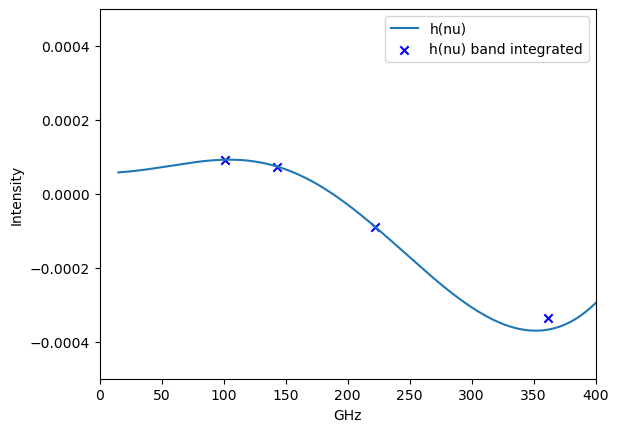

In [6]:
Yp_input = 2e-6
h_nu = f_sz.rel_corr_sec_ord_ysz(Ycl_input, Yp_input, Tcmb, tkev = T_kev, freq_GHz = nu_GHz*(1+Z), const=const, temp = True)
h_nu_band_integrated = f_sz.rel_corr_sec_ord_ysz_bndint(Ycl_input, Yp_input, Tcmb, tkev = T_kev, band_centerfreq = centerfreq, freq_GHz = nu_GHz*(1+Z), const=const, temp = True)

eff_freq = [101.31, 142.709, 221.914, 361.289]

plt.plot(nu_GHz, h_nu, label = "h(nu)")
plt.scatter(eff_freq, h_nu_band_integrated, label = "h(nu) band integrated", marker = 'x', color = 'b')
# plt.scatter(centerfreq, h_nu_band_integrated, label = "h(nu) band integrated", marker = 'x', color = 'b')
plt.ylabel("{}".format("Intensity"))
plt.xlim((0, 400))
plt.ylim((-0.0005, 0.0005))
plt.xlabel("GHz")
plt.legend()

[4.00153942e-07 4.16684117e-07 4.33569975e-07 ... 7.56370335e-05
 7.55710791e-05 7.55049102e-05]


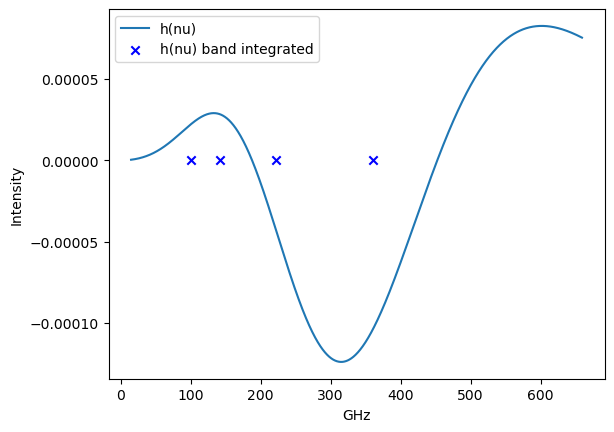

In [12]:
Yp_input = 2e-6
h_nu = f_sz.rel_corr_sec_ord_ysz(Ycl_input, Yp_input, Tcmb, tkev = T_kev, freq_GHz = nu_GHz*(1+Z), const=const, temp = False)*1e24
h_nu_band_integrated = f_sz.rel_corr_sec_ord_ysz_bndint(Ycl_input, Yp_input, Tcmb, tkev = T_kev, band_centerfreq = centerfreq, freq_GHz = nu_GHz*(1+Z), const=const, temp = False)*1e24

eff_freq = [101.31, 142.709, 221.914, 361.289]

print(h_nu)

plt.plot(nu_GHz, h_nu, label = "h(nu)")
plt.scatter(eff_freq, h_nu_band_integrated, label = "h(nu) band integrated", marker = 'x', color = 'b')
# plt.scatter(centerfreq, h_nu_band_integrated, label = "h(nu) band integrated", marker = 'x', color = 'b')
plt.ylabel("{}".format("Intensity"))
#plt.xlim((0, 400))
#plt.ylim((-0.0005, 0.0005))
plt.xlabel("GHz")
plt.legend()

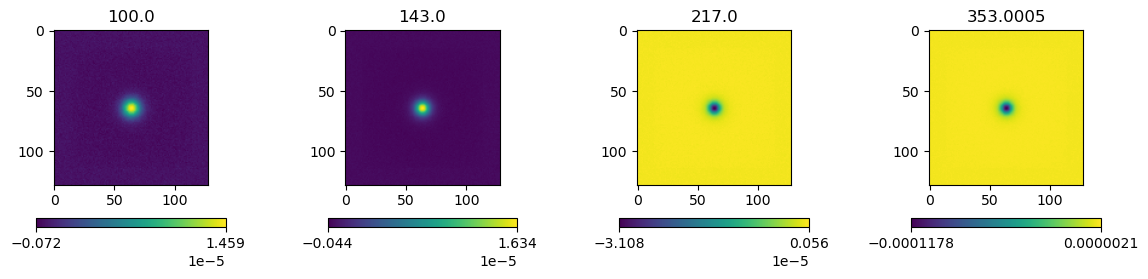

In [41]:
fabbri_map_nu = np.zeros((n_freq,grid_size, grid_size))
for i in range(n_freq):
    fabbri_map = h_nu_band_integrated[i]*cluster_tsz_template[i]
    fabbri_map_nu[i,:,:] = fabbri_map + noise_nu[i]

show_image_line(fabbri_map_nu, labels = centerfreq)

In [42]:
# fit using Cobaya


Ycl_val = 1e-4 # input cluster compton parameter for simulation
Yp_val = 1e-6 # input CMB y-type distortion parameter for simulation
Yp_prior = 3e-6 # mean value for the prior for y-type parameter (COBE result)
Yp_prior_stddev =1e-6 # standard deviation for the prior for the y-type parameter (COBE result)

def likelihood_fabbri(Ycl, Yp):
    # likelikhood = exp(- chi_squure)
    h_nu_band_integrated = f_sz.rel_corr_sec_ord_ysz_bndint(Ycl, Yp, Tcmb, tkev = T_kev, band_centerfreq = centerfreq, freq_GHz = nu_GHz*(1+Z), const=const, temp = True)
    Map_predict_nu = np.zeros((n_freq,grid_size, grid_size))
    for i in range(n_freq):
        Map_predict_nu[i,:,:] = h_nu_band_integrated[i]*cluster_tsz_template[i,:,:]
    chisqr = np.sum((fabbri_map_nu - Map_predict_nu)**2/cluster_var_maps[0:4])
    return -chisqr

a_yp_prior = -Yp_prior/Yp_prior_stddev
b_yp_prior = (1 + Yp_prior)/Yp_prior_stddev

info_Yp={
      "likelihood": {"chisqr": likelihood_fabbri},
      "params":{
                "Ycl": {"prior": {"dist": 'norm', "loc":Ycl_fit, "scale":Ycl_fit_stddev}, "ref": {"dist": 'norm', "loc":Ycl_input, "scale":Ycl_fit_stddev}, "proposal":Ycl_fit_stddev},
                 "Yp": {"prior": {"dist": 'truncnorm', "a": a_yp_prior, "b": b_yp_prior, "loc":Yp_prior, "scale":Yp_prior_stddev}, "proposal":Yp_prior_stddev}                },
      "sampler": {"mcmc": {"Rminus1_stop": 0.004, "max_tries": 100000, "learn_proposal":True}},
      "force": True
      }

info_Yp["output"] = cobaya_output_folder+ "{}_Yp_cobaya_output".format(cluster_name)


updated_info_Yp, sampler_Yp = run(info_Yp)
updated_info_minimizer_Yp, minimizer_Yp = run(info_Yp, minimize=True)

[output] Output to be read-from/written-into folder '/home/vipul/Y-maps/cobaya_output', with prefix 'psz2g346.61+35.06_Yp_cobaya_output'
[output] Found existing info files with the requested output prefix: '/home/vipul/Y-maps/cobaya_output/psz2g346.61+35.06_Yp_cobaya_output'
[output] Will delete previous products ('force' was requested).
[chisqr] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: Ycl:9.998915e-05, Yp:4.284827e-06
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {chisqr: 1370.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-10-16 15:15:17 : 1 steps taken, and 0 accepted.
[mcmc] Learn + converge

   weight  minuslogpost     Ycl        Yp  minuslogprior  minuslogprior__0  \
0     1.0    -28.259508  0.0001  0.000003      -28.26021         -28.26021   

       chi2  chi2__chisqr  
0  0.001404      0.001404  
[root] *WARNING* outlier fraction 0.0012987012987012987 
[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.0009127993975572688,N_eff=1592.2683572900658). Using fallback (h=0.009030401233303065)


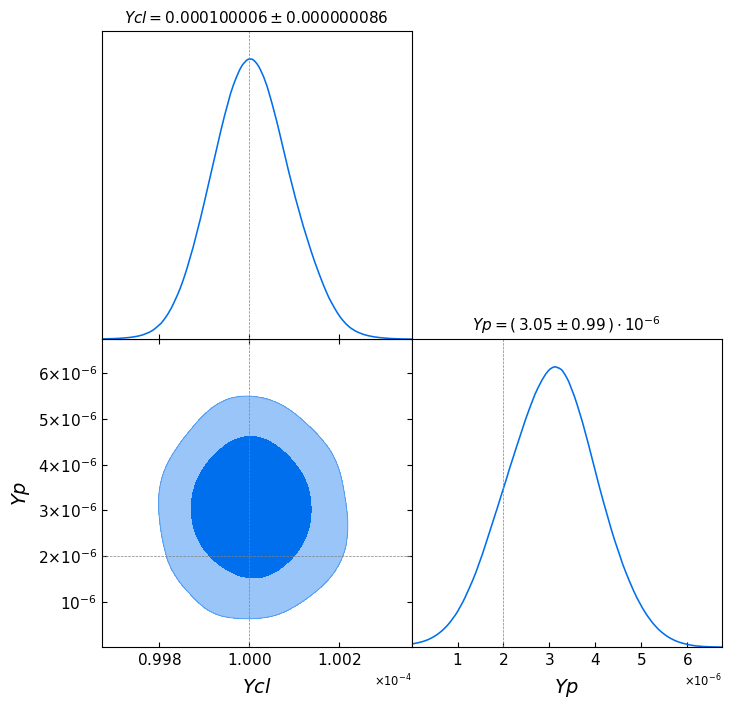

In [43]:
print(minimizer_Yp.products()["minimum"])
peak_ycl = minimizer_Yp.products()["minimum"]["Ycl"]
ycl_limits = {'Ysz': (Ycl_input - 1.5e-4, Ycl_input + 1.5e-4)} #x-axis limits to make the plot symmetric wrt peak.

# Export the results to GetDist
gd_sample = sampler_Yp.products(skip_samples=0.3, to_getdist=True)["sample"]

import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter(subplot_size = 4)
gdplot.triangle_plot(gd_sample, ["Ycl", "Yp"], filled=True, markers={"Ycl":Ycl_input, "Yp": Yp_input},title_limit = 1)